In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import ast
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from evaluate_ec import evaluate_ec_predictions
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns
from collections import defaultdict
import os
import sys
import re
import joblib

from svm_training import SVCWrapper
sys.modules["numpy._core.numeric"] = np.core.numeric

## Loading data

In [2]:
train_df = pd.read_pickle("../dataset/all_features/train.pkl")
valid_df = pd.read_pickle("../dataset/all_features/valid.pkl")
test_df = pd.read_pickle("../dataset/all_features/test.pkl")

In [3]:
train_df

,molecular_weight,isoelectric_point,gravy,aromaticity,instability_index,aliphatic_index,boman_index,ec_0,ec_1,ec_2,...,embedded_310,embedded_311,embedded_312,embedded_313,embedded_314,embedded_315,embedded_316,embedded_317,embedded_318,embedded_319
0,32275.0348,8.347963,-0.154483,0.058621,42.982793,105.862069,0.291586,2,5,1,...,0.077558,0.001130,0.080206,-0.120248,-0.021819,0.108588,-0.067336,0.242951,-0.119197,0.037773
1,529990.8042,6.424364,-0.162032,0.053542,46.634426,90.848941,0.260615,2,3,2,...,0.403116,-0.089608,0.186578,0.010732,-0.215566,0.174769,-0.092853,0.286215,-0.379856,-0.133513
2,527221.8439,5.875981,-0.186202,0.060612,42.951614,90.877120,0.276119,2,3,2,...,0.463706,-0.064925,0.185193,0.007096,-0.191906,0.176897,-0.081807,0.230770,-0.399050,-0.092984
3,37082.7180,5.953111,-0.295385,0.089231,50.063692,94.553846,0.349231,2,5,1,...,0.161103,-0.252514,0.264433,0.026723,0.046471,0.066783,-0.230481,0.264328,-0.078001,-0.073701
4,73292.5257,8.690096,0.295475,0.110106,38.304540,110.030166,0.535460,2,3,1,...,0.011132,0.016021,0.042952,0.004488,-0.071281,-0.026286,-0.051542,0.192327,-0.132582,0.097272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80197,22759.5016,5.341410,-0.167290,0.056075,27.142523,93.224299,0.220327,4,-1,-1,...,-0.159229,0.131705,-0.047043,0.294134,-0.073109,-0.077633,-0.002701,0.404056,-0.036500,-0.090651
80198,66211.6400,5.697165,-0.078089,0.085667,32.443987,86.276771,0.352751,4,1,1,...,-0.064056,-0.101947,-0.062867,0.168465,0.097416,0.007889,-0.065044,0.211190,0.131003,-0.039850
80199,23888.5610,6.828148,0.319626,0.116822,30.216869,104.719626,0.522617,4,1,1,...,0.125881,0.060257,-0.014647,0.114794,-0.119883,-0.091422,-0.147643,0.295883,0.052033,0.028460
80200,28075.0211,5.032434,0.053360,0.051383,39.888142,110.948617,0.367668,4,1,1,...,-0.001975,-0.059719,0.022412,0.014525,0.093250,-0.133975,0.073475,0.180185,0.072995,-0.043402


In [4]:
test_df

,molecular_weight,isoelectric_point,gravy,aromaticity,instability_index,aliphatic_index,boman_index,ec_0,ec_1,ec_2,...,embedded_310,embedded_311,embedded_312,embedded_313,embedded_314,embedded_315,embedded_316,embedded_317,embedded_318,embedded_319
0,31244.5963,6.589935,-0.292701,0.083942,35.858029,94.708029,0.351971,3,6,1,...,-0.028207,-0.124889,-0.019338,0.049703,0.134140,-0.056585,-0.004347,0.155946,-0.025457,-0.062362
1,91703.7386,7.501406,-0.608922,0.095415,48.009170,68.859975,0.175068,3,1,3,...,0.101996,-0.114773,0.154545,0.236475,0.018302,0.103005,-0.066453,0.234637,-0.129185,-0.023201
2,85429.3523,8.992518,-0.547197,0.059974,42.901838,81.186441,0.096988,3,6,4,...,-0.015989,-0.158081,0.011028,0.147337,-0.075196,0.007365,0.011320,0.252092,-0.031869,-0.056613
3,238520.6175,8.151592,-0.347029,0.058032,46.601862,87.400186,0.206356,3,6,4,...,0.182922,-0.083622,0.139432,0.102394,-0.011620,0.171464,-0.073754,0.131539,-0.068794,0.049631
4,32652.1900,9.253421,-0.484752,0.117021,27.952163,86.099291,0.292021,3,1,26,...,0.219853,0.026792,0.027346,0.012373,0.092634,-0.072475,-0.165071,0.082209,0.022070,0.050083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8176,32403.6261,6.557480,-0.588850,0.062718,37.762718,82.857143,0.186585,2,7,1,...,0.050977,-0.010082,-0.105220,0.173631,0.155622,-0.018332,-0.064451,0.146793,-0.009285,0.049983
8177,50614.7558,5.565185,-0.030110,0.083516,34.673407,95.186813,0.413341,2,4,1,...,-0.026729,-0.229688,-0.018234,0.247280,-0.149357,0.048370,-0.062502,0.083329,-0.035022,0.071541
8178,32683.2839,6.855999,-0.028136,0.067797,30.228136,109.084746,0.374508,2,1,1,...,0.109706,-0.192589,0.104254,0.145912,0.024436,-0.161010,-0.143918,0.090552,-0.100088,-0.084263
8179,45490.2139,7.631908,-0.233171,0.082927,24.039537,87.292683,0.338293,2,7,7,...,0.024549,0.142268,-0.155269,-0.000037,0.132831,-0.176046,-0.133629,0.145829,0.055308,0.036210


## Data Processing

In [4]:
def get_feature_and_label(df):
    ec_cols = [col for col in df.columns if col.startswith('ec_')]
    return df.drop(columns=ec_cols), df[ec_cols]

In [5]:
all_feature_names = train_df.columns.tolist()

In [6]:
train_X, train_Y = get_feature_and_label(train_df)
valid_X, valid_Y = get_feature_and_label(valid_df)
test_X, test_Y = get_feature_and_label(test_df)

# with open("../metrics/feature_selection_results/final_indices.pkl", "rb") as f:
#     final_indices = pickle.load(f)
#     train_X = train_X.iloc[:, final_indices]
#     valid_X = valid_X.iloc[:, final_indices]
#     test_X = test_X.iloc[:, final_indices]

scaler = MinMaxScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X).astype(np.float32)
valid_X = scaler.transform(valid_X).astype(np.float32)
test_X = scaler.transform(test_X).astype(np.float32)

In [8]:
train_Y

,ec_0,ec_1,ec_2,ec_3
0,2,5,1,61
1,2,3,2,26
2,2,3,2,26
3,2,5,1,83
4,2,3,1,78
...,...,...,...,...
80197,4,-1,-1,-1
80198,4,1,1,1
80199,4,1,1,65
80200,4,1,1,48


## Ablation Studies

In [9]:
# !python ablation_study.py

In [9]:
ab_df = pd.read_csv("../metrics/Ablation_Results/all_ablation_eval_reports.csv")
ab_df

,Method,Exact Match Accuracy,No EC number found,No Prediction,Position 1 Accuracy,Position 1 Precision,Position 1 Recall,Position 1 F1-Score,Position 2 Accuracy,Position 2 Precision,Position 2 Recall,Position 2 F1-Score,Position 3 Accuracy,Position 3 Precision,Position 3 Recall,Position 3 F1-Score,Position 4 Accuracy,Position 4 Precision,Position 4 Recall,Position 4 F1-Score
0,AllFeatures,0.200953,0.0,0.0,0.696981,0.641987,0.734980,0.660710,0.570101,0.256564,0.631226,0.319240,0.578291,0.163593,0.538033,0.218226,0.162694,0.745969,0.770020,0.754288
1,Remove_HMM,0.200953,0.0,0.0,0.698325,0.641944,0.738155,0.662777,0.569735,0.256088,0.635444,0.320242,0.578536,0.164681,0.529371,0.218510,0.163672,0.803192,0.829527,0.810585
2,Remove_PSSM,0.294218,0.0,0.0,0.751131,0.715215,0.766597,0.729368,0.642220,0.342164,0.641998,0.412130,0.628896,0.244631,0.652243,0.322488,0.257792,0.645074,0.640478,0.637342
3,Remove_Physiochemical,0.201565,0.0,0.0,0.697470,0.642140,0.735235,0.661223,0.563745,0.256494,0.591142,0.320394,0.576335,0.164622,0.570973,0.221369,0.164405,0.787033,0.806180,0.790757
4,Remove_QSAR,0.202542,0.0,0.0,0.695881,0.640030,0.735008,0.660891,0.573157,0.250479,0.578047,0.307443,0.578169,0.162345,0.537111,0.218234,0.164283,0.762603,0.793964,0.771375
5,Remove_Sequence_Embedding,0.039482,0.0,0.0,0.421709,0.326904,0.573014,0.330550,0.325999,0.073624,0.181912,0.071792,0.474025,0.047451,0.229186,0.044526,0.027747,0.713563,0.707291,0.708905
6,Remove_Sequenctial,0.203276,0.0,0.0,0.690747,0.635113,0.733113,0.655189,0.575480,0.271468,0.636571,0.339626,0.578047,0.165470,0.530020,0.219888,0.163550,0.732457,0.750151,0.735999


## Feature reduction

In [ ]:
# !python feature_selection.py

### Variance Selection Visualization

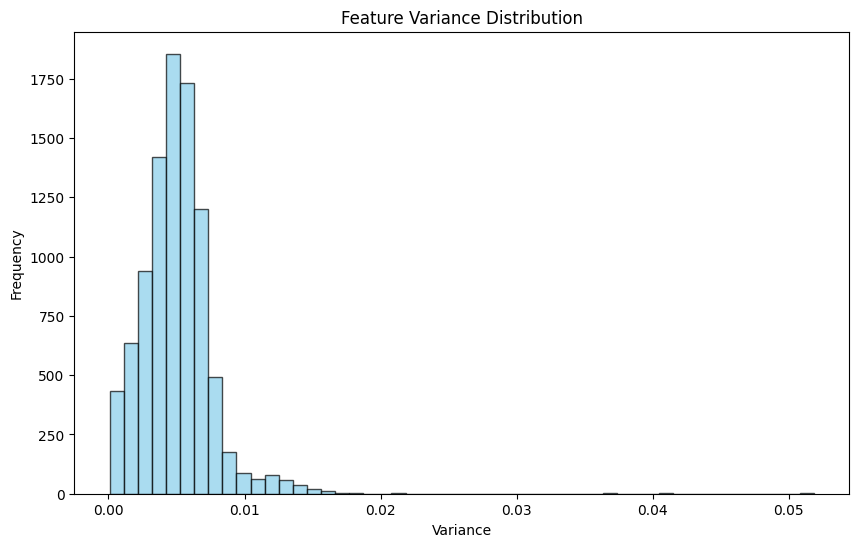

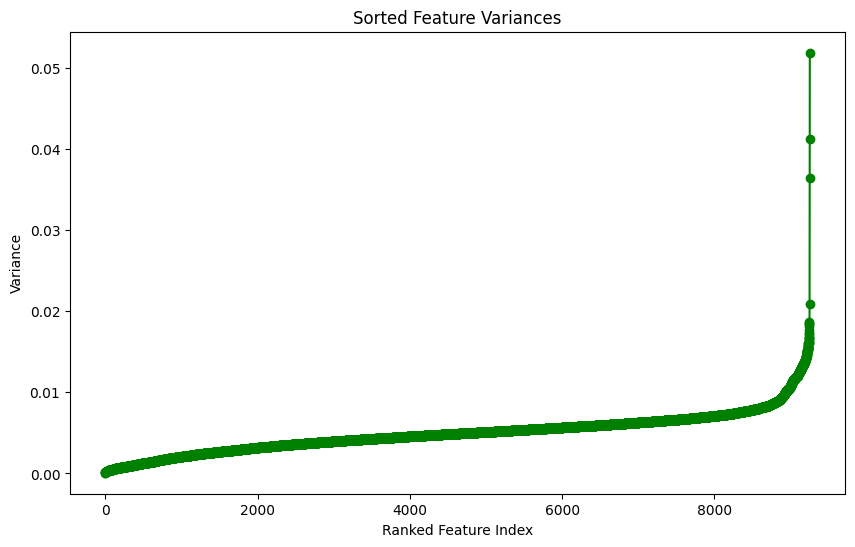

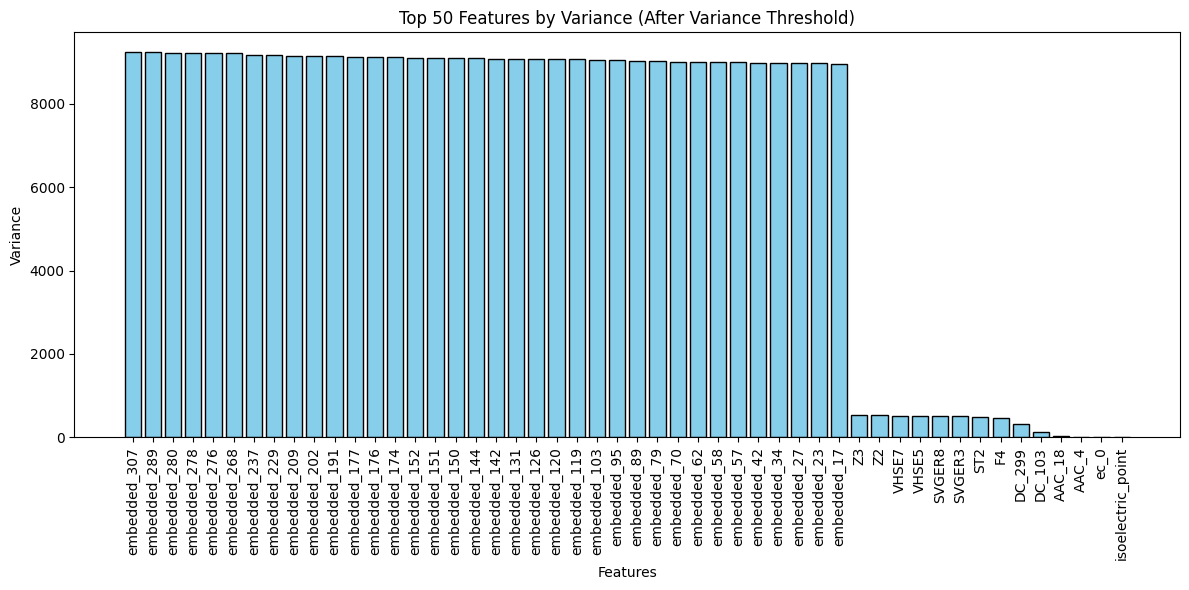

In [10]:
with open("../metrics/feature_selection_results/variance_info.pkl", "rb") as f:
    variance_info = pickle.load(f)
variances = variance_info["variances"]
var_indices = variance_info['feature_indices']
variance_ranking_filtered = variance_info["ranking"]
var_filtered_feature_names = [all_feature_names[i] for i in var_indices]

plt.figure(figsize=(10,6))
plt.hist(variances, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Feature Variance Distribution")
plt.xlabel("Variance")
plt.ylabel("Frequency")
plt.savefig('../metrics/feature_selection_results/Feature_Variance_Distribution.png', dpi=300, bbox_inches='tight')
plt.show()

ranking = variance_info["ranking"]
sorted_variances = variances[ranking]

plt.figure(figsize=(10,6))
plt.plot(range(len(sorted_variances)), sorted_variances, marker='o', linestyle='-', color='green')
plt.title("Sorted Feature Variances")
plt.xlabel("Ranked Feature Index")
plt.ylabel("Variance")
plt.savefig('../metrics/feature_selection_results/Sorted_Feature_Variances.png', dpi=300, bbox_inches='tight')
plt.show()

top_k = 50
if len(var_indices) < top_k:
    top_k = len(var_indices)

top_50_indices = variance_ranking_filtered[-top_k:]
top_50_variances = var_indices[top_50_indices]
top_50_names = [var_filtered_feature_names[i] for i in top_50_indices]

sort_order = np.argsort(-top_50_variances)
top_50_variances_sorted = top_50_variances[sort_order]
top_50_names_sorted = [top_50_names[i] for i in sort_order]

plt.figure(figsize=(12, 6))
plt.bar(range(top_k), top_50_variances_sorted, color='skyblue', edgecolor='black')
plt.title("Top 50 Features by Variance (After Variance Threshold)")
plt.xlabel("Features")
plt.ylabel("Variance")
plt.xticks(range(top_k), top_50_names_sorted, rotation=90)
plt.tight_layout()
plt.savefig('../metrics/feature_selection_results/Top50_Features_Var.png', dpi=300, bbox_inches='tight')
plt.show()

### Mutual Info Visualization

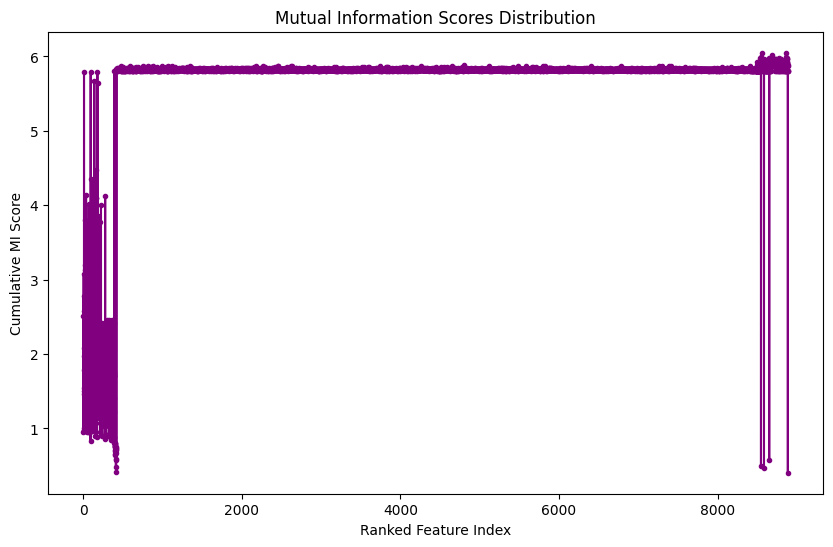

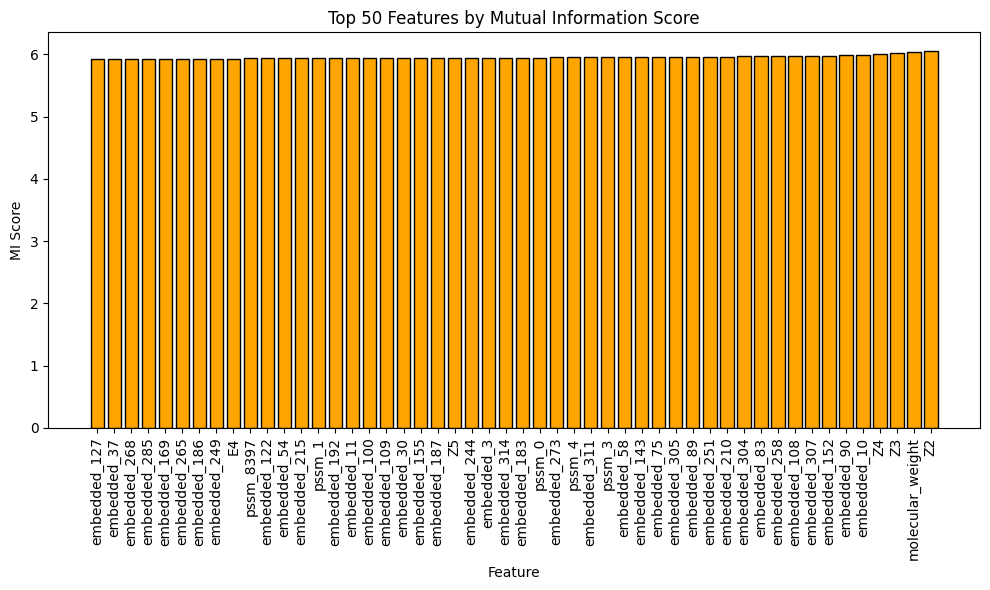

In [12]:
with open("../metrics/feature_selection_results/mutual_info_ranking_all.pkl", "rb") as f:
    mi_ranking_all = pickle.load(f)
sorted_indices = mi_ranking_all["sorted_indices"]
sorted_scores = mi_ranking_all["scores"]

plt.figure(figsize=(10,6))
plt.plot(range(len(sorted_scores)), sorted_scores[sorted_indices], marker='.', linestyle='-', color='purple')
plt.title("Mutual Information Scores Distribution")
plt.xlabel("Ranked Feature Index")
plt.ylabel("Cumulative MI Score")
plt.savefig('../metrics/feature_selection_results/Sorted_Mutual_Information_Scores.png', dpi=300, bbox_inches='tight')
plt.show()

with open("../metrics/feature_selection_results/mutual_info_top_ranking.pkl", "rb") as f:
    top_info = pickle.load(f)
top_scores = top_info["top_scores"]
original_indices = top_info["original_feature_indices"]
mi_feature_names = [all_feature_names[i] for i in original_indices]

top_k = 50
sorted_indices = np.argsort(top_scores)
top_indices = sorted_indices[-top_k:]

plot_scores = top_scores[top_indices]
plot_names = [mi_feature_names[i] for i in top_indices]

plt.figure(figsize=(10,6))
plt.bar(range(top_k), plot_scores, color='orange', edgecolor='black')
plt.title("Top 50 Features by Mutual Information Score")
plt.xlabel("Feature")
plt.ylabel("MI Score")
plt.xticks(range(top_k), plot_names, rotation=90)
plt.tight_layout()
plt.savefig('../metrics/feature_selection_results/To50_Features_MI.png', dpi=300, bbox_inches='tight')
plt.show()

### Visualize RFE results

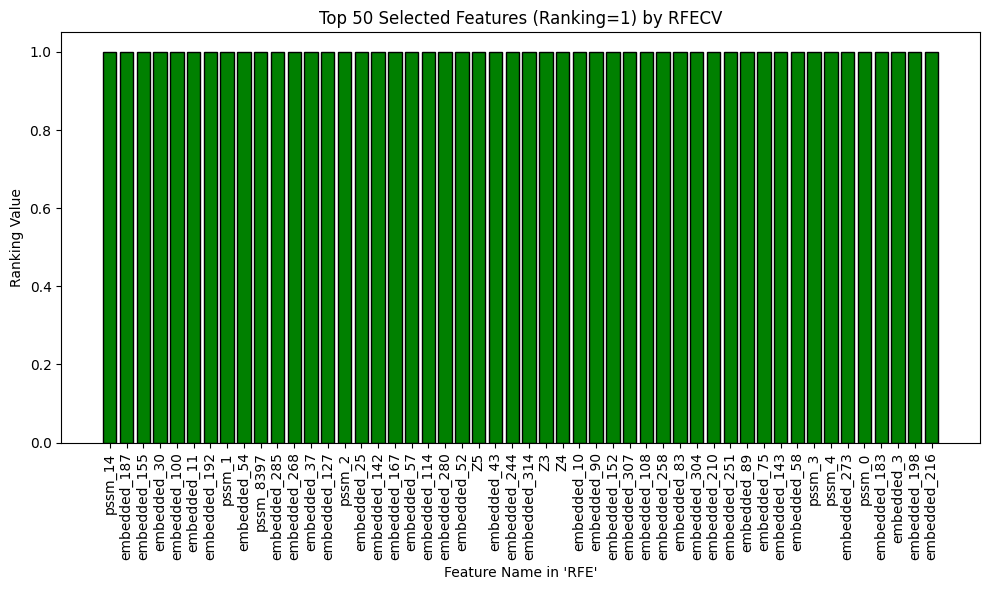

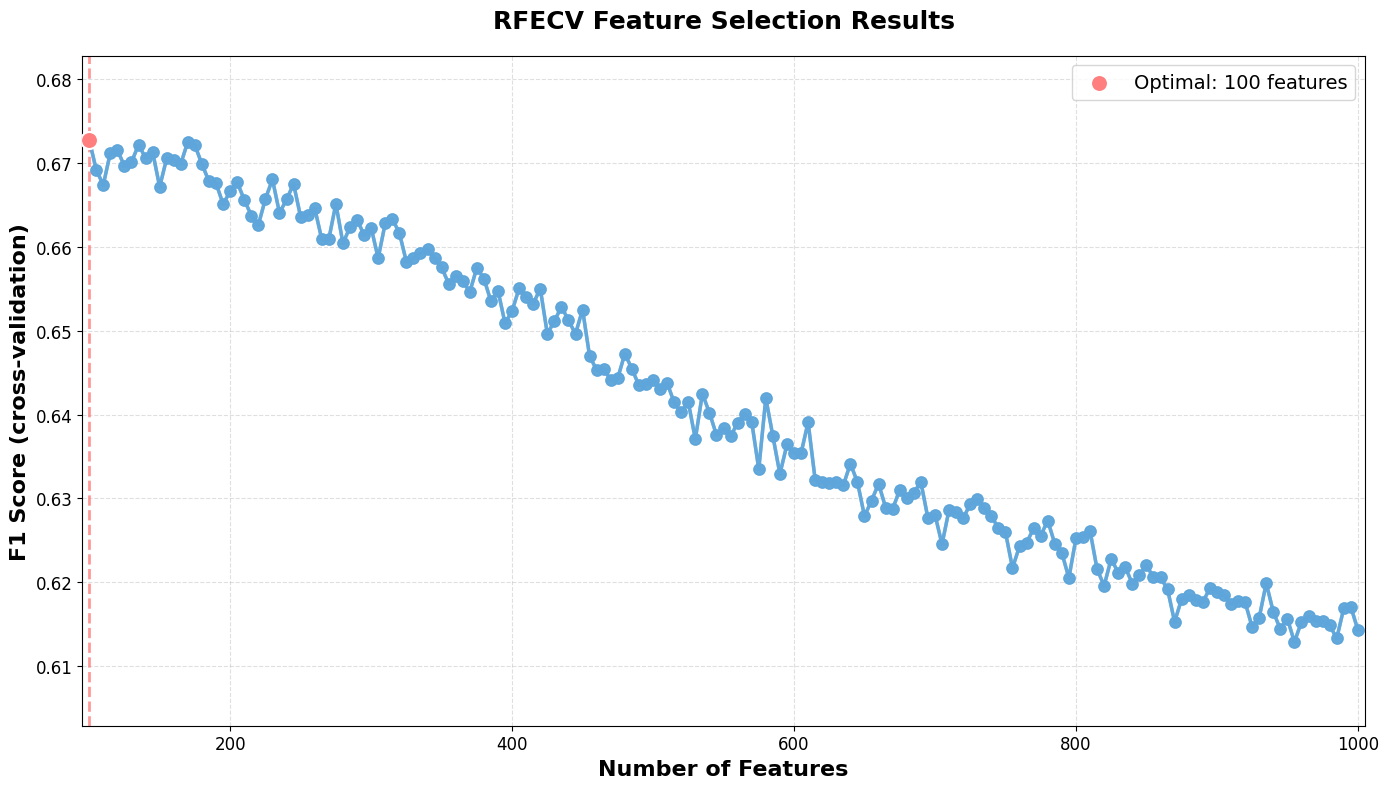

Optimal number of features: 100
Approx. F1 score at 100 features: 0.6728


In [13]:
with open("../metrics/feature_selection_results/rfecv_ranking_info.pkl", "rb") as f:
    rfe_info = pickle.load(f)
ranking = rfe_info["rfecv_ranking"]   # shape (num_features_after_MI,)
support = rfe_info["support"]         # shape (num_features_after_MI,)

with open("../metrics/feature_selection_results/final_indices.pkl", "rb") as f:
    final_indices = pickle.load(f)
final_feature_names = [all_feature_names[i] for i in final_indices]

ranking_selected = ranking[support]
top_k = 50
if len(final_indices) < top_k:
    top_k = len(final_indices)

selected_feature_indices = np.argsort(ranking[support])[:top_k]
selected_feature_names = [final_feature_names[i] for i in selected_feature_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(top_k), ranking[support][selected_feature_indices], color='green', edgecolor='black')
plt.title("Top 50 Selected Features (Ranking=1) by RFECV")
plt.xlabel("Feature Name in 'RFE'")
plt.ylabel("Ranking Value")
plt.xticks(range(top_k), selected_feature_names, rotation=90)
plt.tight_layout()
plt.savefig('../metrics/feature_selection_results/To50_Features_RFE.png', dpi=300, bbox_inches='tight')
plt.show()


with open("../metrics/feature_selection_results/grid_scores.pkl", "rb") as f:
    cv_results = pickle.load(f)
mean_scores = cv_results["mean_test_score"]  # shape (n_iterations,)
std_scores = cv_results["std_test_score"]    # shape (n_iterations,)

if "std_test_score" in cv_results:
    std_scores = cv_results["std_test_score"]
else:
    std_scores = np.zeros_like(mean_scores)

optimal_n_features = len(final_indices)

if "n_features" in cv_results:
    n_features = cv_results["n_features"]
else:
    step_size = 5
    start_features = 1000
    min_features = 100
    n_features_list = []
    cur = start_features
    while cur > min_features:
        n_features_list.append(cur)
        cur -= step_size
    if cur < min_features:
        n_features_list.append(min_features)
    if len(n_features_list) > len(mean_scores):
        n_features_list = n_features_list[:len(mean_scores)]
    elif len(n_features_list) < len(mean_scores):
        n_features_list = np.linspace(n_features_list[0], n_features_list[-1], 
                                      len(mean_scores)).astype(int)
    n_features = n_features_list

n_features = np.array(n_features)
mean_scores = np.array(mean_scores)
std_scores = np.array(std_scores)
plt.figure(figsize=(14, 8))

plt.plot(n_features, mean_scores, 'o-', color='#5DA5DA',
         linewidth=2.5, markersize=8, alpha=0.8)

plt.errorbar(n_features, mean_scores, yerr=std_scores,
             fmt='o-', color='#5DA5DA',
             linewidth=2.5, markersize=8, alpha=0.8, capsize=3)

plt.xlabel('Number of Features', fontsize=16, fontweight='bold')
plt.ylabel('F1 Score (cross-validation)', fontsize=16, fontweight='bold')
plt.title('RFECV Feature Selection Results', fontsize=18, fontweight='bold', pad=20)
plt.grid(True, linestyle='--', alpha=0.4)

if np.any(n_features >= optimal_n_features):
    optimal_idx = np.where(n_features >= optimal_n_features)[0][0]
    plt.axvline(x=n_features[optimal_idx], color='#FF7F7F', linestyle='--', alpha=0.8, linewidth=2)
    plt.scatter(n_features[optimal_idx], mean_scores[optimal_idx], 
                color='#FF7F7F', s=150, zorder=5, edgecolor='white', linewidth=1.5,
                label=f'Optimal: {optimal_n_features} features')
else:
    optimal_idx = -1

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14, frameon=True, facecolor='white', edgecolor='#CCCCCC')

plt.xlim(n_features.min() - 5, n_features.max() + 5)
plt.ylim(mean_scores.min() - 0.01, mean_scores.max() + 0.01)

plt.tight_layout()
plt.savefig('../metrics/feature_selection_results/rfecv_feature_selection.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Optimal number of features: {optimal_n_features}")
if optimal_idx >= 0:
    print(f"Approx. F1 score at {optimal_n_features} features: {mean_scores[optimal_idx]:.4f}")

In [7]:
def multioutput_f1_score(y_true, y_pred):
    # Flatten all outputs and compute micro-F1
    return f1_score(y_true.ravel(), y_pred.ravel(), average='micro', zero_division=0)

In [8]:
X_trainval = np.concatenate([train_X, valid_X], axis=0).astype(np.float32)
y_trainval = np.concatenate([train_Y, valid_Y], axis=0)
split_index = np.concatenate([
    np.full(len(train_X), -1),  # Training samples (-1 means they are used for training)
    np.full(len(valid_X), 0)    # Validation samples (0 means they are used for validation)
])
# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)
f1_scorer = make_scorer(multioutput_f1_score)

### Single Random Forest

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

# Set up the RandomForestClassifier (no MultiOutputClassifier needed)

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=pds,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_trainval, y_trainval)

# Best parameters and best F1 score
print("Best params:", grid_search.best_params_)
print("Best F1:", grid_search.best_score_)

In [ ]:
# Evaluate on the test set
# best_params = grid_search.best_params_
# best_model = RandomForestClassifier(random_state=42, **best_params)
best_model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=None)
best_model.fit(X_trainval, y_trainval)

In [9]:
test_pred = best_model.predict(test_X)
final_f1 = multioutput_f1_score(test_Y.to_numpy(), test_pred)
print("Test F1:", final_f1)
eval_report = evaluate_ec_predictions(test_pred, test_Y.to_numpy(), "Final Selected Features + RF")
eval_report

IndexError: list index out of range

#### Save model - All features version

In [ ]:
joblib.dump(best_model, "Models/selected_single_models_RandomForest.pkl", compress=3)

In [ ]:
best_model = joblib.load("Models/selected_single_models_RandomForest.pkl")

### Save model - Selected version (100 features)

In [13]:
joblib.dump(best_model, "Selected_Feature_Models/selected_single_models_RandomForest.pkl", compress=3)

['Selected_Feature_Models/selected_single_models_RandomForest.pkl']

In [ ]:
best_model = joblib.load("Selected_Feature_Models/selected_single_models_RandomForest.pkl")

#### Visualize results

In [11]:
metrics = pd.read_csv('../metrics/experiment_results.csv')
report_combined = pd.concat([metrics, eval_report], axis=0, ignore_index=True)
display(report_combined)
report_combined.to_csv('../metrics/experiment_results.csv', index=False)

,Method,Exact Match Accuracy,No EC number found,No Prediction,Position 1 Accuracy,Position 1 Precision,Position 1 Recall,Position 1 F1-Score,Position 2 Accuracy,Position 2 Precision,Position 2 Recall,Position 2 F1-Score,Position 3 Accuracy,Position 3 Precision,Position 3 Recall,Position 3 F1-Score,Position 4 Accuracy,Position 4 Precision,Position 4 Recall,Position 4 F1-Score
0,Diamond Benchmark,0.039201,0.941015,0.941015,0.055688,0.721168,0.037458,0.070890,0.053306,0.486238,0.031849,0.058538,0.049460,0.586344,0.039202,0.072057,0.039201,0.275194,0.044003,0.068529
1,Physiochemical + HMM + RF,0.045349,0.000000,0.000000,0.428798,0.308276,0.728130,0.301557,0.374160,0.106004,0.313204,0.119088,0.484537,0.056081,0.316874,0.060274,0.044616,0.458614,0.523714,0.474899
2,Physiochemical + HMM + MultiRF,0.035204,0.000000,0.000000,0.420609,0.297715,0.720197,0.285135,0.364992,0.098482,0.356674,0.108555,0.489060,0.064475,0.313242,0.074011,0.201809,0.055158,0.203867,0.072607
3,Physiochemical + HMM + Peptides + RF,0.070774,0.000000,0.000000,0.461313,0.347138,0.694721,0.351522,0.412541,0.134055,0.411474,0.159142,0.498105,0.073154,0.399611,0.089062,0.062951,0.606769,0.651824,0.620800
4,Physiochemical + HMM + Peptides + CascadeRF,0.095954,0.000000,0.000000,0.458624,0.343595,0.714645,0.346260,0.398362,0.132142,0.396339,0.150091,0.514240,0.095252,0.412118,0.120354,0.263415,0.118571,0.246855,0.135757
5,Physiochemical + HMM + Peptides + PSSM + RF,0.067718,0.000000,0.000000,0.453979,0.333541,0.759008,0.332330,0.405696,0.119101,0.294561,0.136110,0.497372,0.067890,0.321592,0.079612,0.063195,0.706811,0.715351,0.709565
6,Physiochemical + HMM + Peptides + PSSM + casca...,0.077619,0.000000,0.000000,0.510084,0.446397,0.546721,0.469172,0.422076,0.207611,0.414095,0.241548,0.505928,0.168118,0.272338,0.191071,0.131402,0.061022,0.070654,0.057763
7,Physiochemical + HMM + Peptides + PSSM + casca...,0.259381,0.000000,0.000000,0.545166,0.527139,0.569718,0.540062,0.482093,0.275633,0.444429,0.306142,0.509718,0.204441,0.319686,0.227702,0.287251,0.147640,0.206916,0.153825
8,Physiochemical + HMM + Peptides + PSSM + casca...,0.066740,0.000000,0.000000,0.426720,0.388000,0.461339,0.406603,0.353502,0.116847,0.253173,0.124335,0.490527,0.099567,0.204391,0.118891,0.203398,0.068700,0.141904,0.079934
9,Physiochemical + HMM + Peptides + PSSM + casca...,0.079208,0.000000,0.000000,0.451167,0.328859,0.756411,0.322414,0.410952,0.122561,0.281608,0.135531,0.506784,0.078407,0.366446,0.094109,0.250458,0.089056,0.231272,0.113617


In [11]:
test_X.shape

(8181, 100)

In [13]:
test_Y

,ec_0,ec_1,ec_2,ec_3
0,3,6,1,41
1,3,1,3,48
2,3,6,4,13
3,3,6,4,-1
4,3,1,26,3
...,...,...,...,...
8176,2,7,1,176
8177,2,4,1,-1
8178,2,1,1,182
8179,2,7,7,4


Saved ROC curve: ../metrics/roc_curves/RandomForest_Final/ROC_EC_0.png
Saved ROC curve: ../metrics/roc_curves/RandomForest_Final/ROC_EC_1.png
Saved ROC curve: ../metrics/roc_curves/RandomForest_Final/ROC_EC_2.png
Saved ROC curve: ../metrics/roc_curves/RandomForest_Final/ROC_EC_3.png


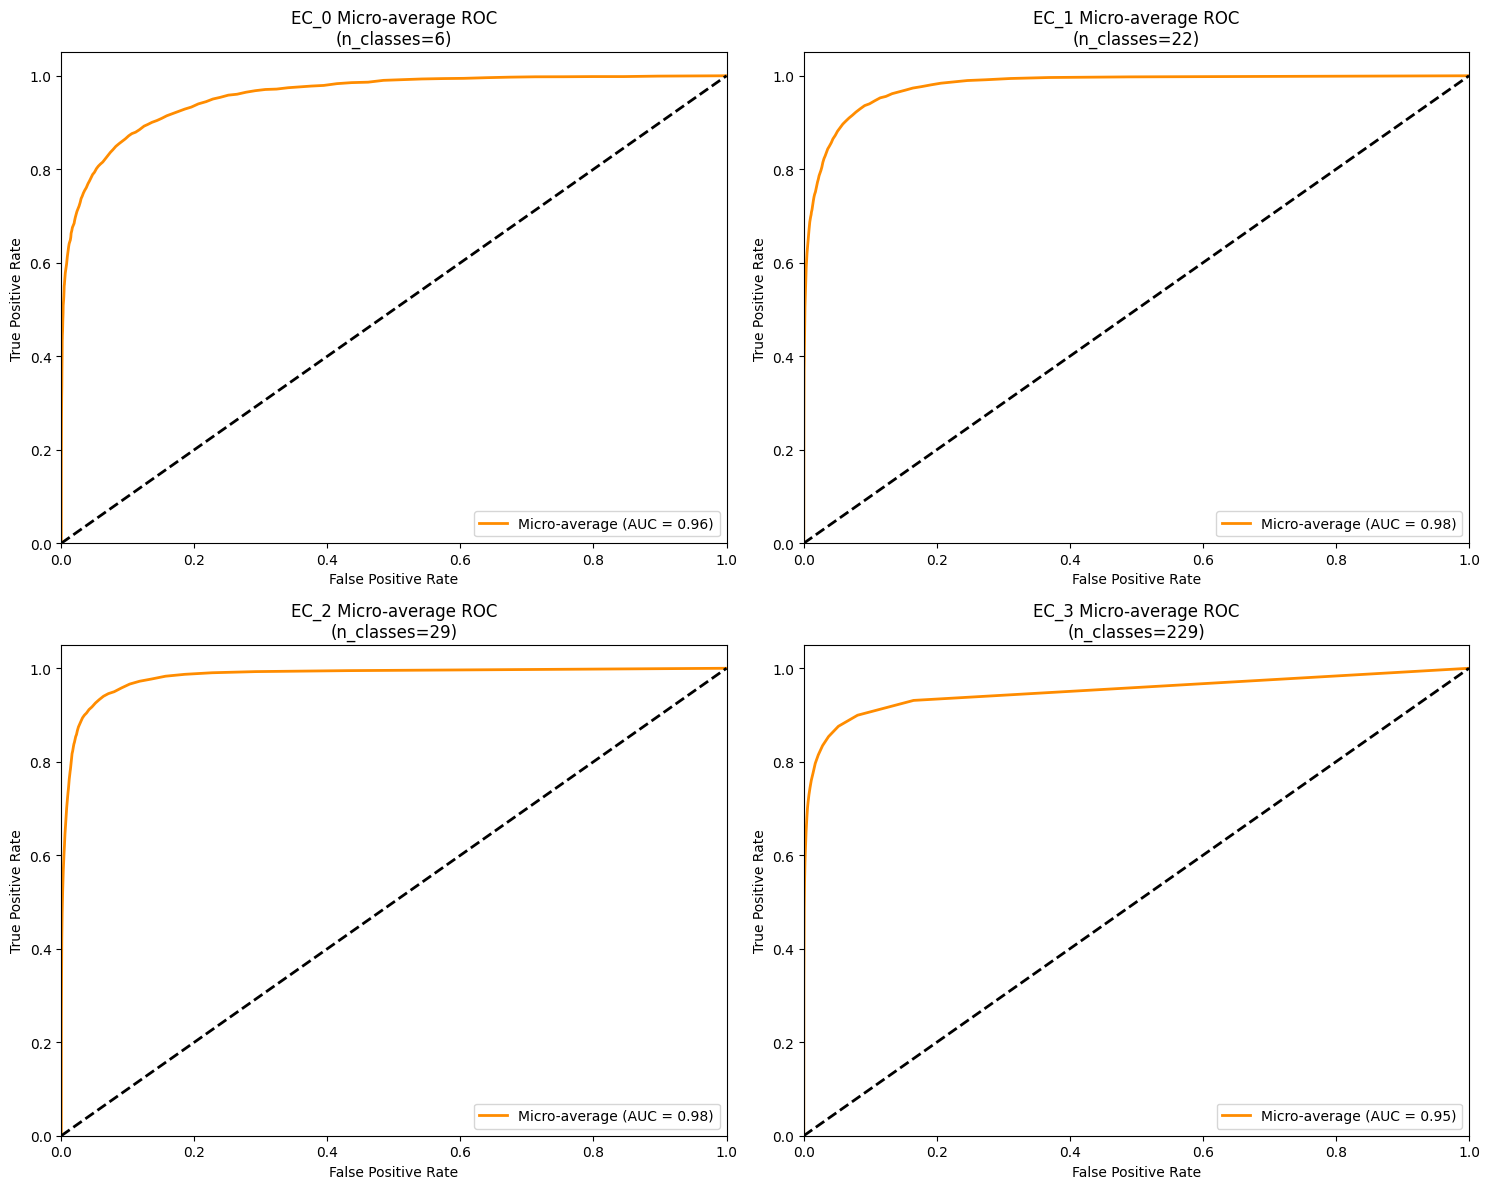

Saved combined ROC plot: ../metrics/roc_curves/combined_ROC/Combined_ROC_EC_0.png
Saved combined ROC plot: ../metrics/roc_curves/combined_ROC/Combined_ROC_EC_1.png
Saved combined ROC plot: ../metrics/roc_curves/combined_ROC/Combined_ROC_EC_2.png
Saved combined ROC plot: ../metrics/roc_curves/combined_ROC/Combined_ROC_EC_3.png


In [ ]:
test_probs = best_model.predict_proba(test_X)

# Initialize global storage for ROC data comparison if not already defined
if 'roc_comparison_data' not in globals():
    roc_comparison_data = defaultdict(lambda: {
        'model_names': [],
        'fprs': [],
        'tprs': [],
        'auc_scores': []
    })

# Ensure necessary directories exist
results_base_folder = "../metrics"
os.makedirs(results_base_folder, exist_ok=True)

# Create organized subfolder structure
roc_curves_folder = os.path.join(results_base_folder, "roc_curves")
combined_roc_folder = os.path.join(roc_curves_folder, "Selected_Random_Forest")
model_name = "selected_single_RandomForest"  # Change this to your desired model name
model_roc_folder = os.path.join(roc_curves_folder, model_name)

# Create all necessary folders
for folder in [roc_curves_folder, model_roc_folder, combined_roc_folder]:
    os.makedirs(folder, exist_ok=True)

# Create visualization canvas for overall view
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs = axs.ravel()

# Iterate through each EC output
for output_idx in range(4):
    # Get current output data
    current_ax = axs[output_idx]
    
    # Extract raw data
    y_true_full = test_Y.iloc[:, output_idx].to_numpy()
    prob_matrix_full = test_probs[output_idx]
    
    # Filter invalid labels
    valid_mask = y_true_full != -1
    y_true = y_true_full[valid_mask]
    prob_matrix = prob_matrix_full[valid_mask, :]
    
    # Get actually existing classes (sorted)
    classes = np.sort(np.unique(y_true))
    
    # Find common classes between test data and model classes
    model_classes = best_model.classes_[output_idx]
    common_classes = np.array([cls for cls in classes if cls in model_classes])
    
    if len(common_classes) == 0:
        # No common classes, skip this output
        current_ax.text(0.5, 0.5, f"No common classes for EC_{output_idx}", 
                       ha='center', va='center', transform=current_ax.transAxes)
        continue
    
    # Keep only samples with common classes
    common_mask = np.isin(y_true, common_classes)
    y_true_common = y_true[common_mask]
    prob_matrix_common = prob_matrix[common_mask, :]
    
    n_classes = len(common_classes)
    
    # Binarize true labels for common classes
    y_true_bin = label_binarize(y_true_common, classes=common_classes)
    
    # Create a mapping for probability values
    prob_matrix_ordered = np.zeros((len(y_true_common), n_classes))
    for idx, cls in enumerate(common_classes):
        # Find the index of this class in the model's classes
        try:
            original_col_idx = np.where(model_classes == cls)[0][0]
            prob_matrix_ordered[:, idx] = prob_matrix_common[:, original_col_idx]
        except (IndexError, ValueError):
            # Class not found in model classes, set probabilities to 0
            print(f"Warning: Class {cls} not found in model classes for EC_{output_idx}")
            prob_matrix_ordered[:, idx] = 0
    
    # Compute micro-average ROC curve and ROC area
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute micro-average ROC curve and ROC area
    try:
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), prob_matrix_ordered.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # Plot micro-average ROC curve
        current_ax.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2,
                       label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')
        
        # Save data for comparison with other models
        roc_comparison_data[output_idx]['model_names'].append(model_name)
        roc_comparison_data[output_idx]['fprs'].append(fpr["micro"])
        roc_comparison_data[output_idx]['tprs'].append(tpr["micro"])
        roc_comparison_data[output_idx]['auc_scores'].append(roc_auc["micro"])
        
        # Also create individual plot files for this EC level
        plt.figure(figsize=(8, 6))
        plt.plot(fpr["micro"], tpr["micro"], 
                 label=f'Micro-avg (AUC = {roc_auc["micro"]:.2f})',
                 color='deeppink', linestyle=':', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"ROC for {model_name} - EC_{output_idx}")
        plt.legend(loc="lower right")
        
        roc_filename = os.path.join(model_roc_folder, f"ROC_EC_{output_idx}.png")
        plt.savefig(roc_filename, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved ROC curve: {roc_filename}")
        
    except ValueError as e:
        # Handle potential errors in ROC curve calculation
        print(f"Error calculating ROC curve for EC_{output_idx}: {str(e)}")
        current_ax.text(0.5, 0.5, f"Error calculating ROC for EC_{output_idx}\n{str(e)}", ha='center', va='center', transform=current_ax.transAxes)
        continue
    
    # Set graph parameters
    current_ax.plot([0, 1], [0, 1], 'k--', lw=2)
    current_ax.set_xlim([0.0, 1.0])
    current_ax.set_ylim([0.0, 1.05])
    current_ax.set_xlabel('False Positive Rate')
    current_ax.set_ylabel('True Positive Rate')
    current_ax.set_title(f'EC_{output_idx} Micro-average ROC\n(n_classes={n_classes})')
    current_ax.legend(loc="lower right")

# Save the overview figure
plt.tight_layout()
overview_filename = os.path.join(model_roc_folder, "ROC_Overview.png")
plt.savefig(overview_filename, dpi=300, bbox_inches='tight')
plt.show()

# Create combined ROC plots for all models
# This should be run after all models have been processed
for i in range(4):  # 4 EC levels
    if i not in roc_comparison_data or len(roc_comparison_data[i]['model_names']) == 0:
        print(f"No ROC data available for EC_{i}")
        continue
    
    plt.figure(figsize=(10, 8))
    
    # Plot ROC for each model
    for j, model_name in enumerate(roc_comparison_data[i]['model_names']):
        fpr = roc_comparison_data[i]['fprs'][j]
        tpr = roc_comparison_data[i]['tprs'][j]
        auc_score = roc_comparison_data[i]['auc_scores'][j]
        
        plt.plot(
            fpr, tpr, 
            label=f'{model_name} (AUC = {auc_score:.2f})',
            lw=2
        )
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'Combined ROC Curves for EC_{i}', fontsize=14)
    
    # Adjust legend based on number of models
    if len(roc_comparison_data[i]['model_names']) > 6:
        plt.legend(loc="lower right", fontsize=8)
    else:
        plt.legend(loc="lower right", fontsize=10)
    
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Save the combined plot
    combined_filename = os.path.join(combined_roc_folder, f"Combined_ROC_EC_{i}.png")
    plt.savefig(combined_filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved combined ROC plot: {combined_filename}")

In [25]:
roc_comparison_data_dict = dict(roc_comparison_data) # defaultdict cannot be pickled
with open("../metrics/roc_curves/selected_roc_comparison_data.pkl", "wb") as f:
    pickle.dump(roc_comparison_data_dict, f)

### Cascade Modelling

In [ ]:
# !python model_selection.py

In [ ]:
# Ensure necessary directories exist
models_folder = "Models"
results_base_folder = "../metrics"
os.makedirs(results_base_folder, exist_ok=True)

# Create organized subfolder structure
confusion_matrix_folder = os.path.join(results_base_folder, "confusion_matrices")
roc_curves_folder = os.path.join(results_base_folder, "roc_curves")
reports_folder = os.path.join(results_base_folder, "evaluation_reports")

# Create all necessary folders
for folder in [confusion_matrix_folder, roc_curves_folder, reports_folder]:
    os.makedirs(folder, exist_ok=True)

# Initialize global storage for ROC data comparison
roc_comparison_data = defaultdict(lambda: {
    'model_names': [],
    'fprs': [],
    'tprs': [],
    'auc_scores': []
})

all_eval_reports = None

# Get all model files from the directory
pkl_files = [f for f in os.listdir(models_folder) if f.endswith(".pkl")]

# Process each model file
for pkl_file in pkl_files:
    model_path = os.path.join(models_folder, pkl_file)
    model_name = f"{os.path.splitext(pkl_file)[0]}"
    print(f"Processing model file: {pkl_file}")
    
    # Create model-specific subfolders
    model_cm_folder = os.path.join(confusion_matrix_folder, model_name)
    model_roc_folder = os.path.join(roc_curves_folder, model_name)
    os.makedirs(model_cm_folder, exist_ok=True)
    os.makedirs(model_roc_folder, exist_ok=True)
    
    # Load trained cascade models
    with open(model_path, "rb") as f:
        models = pickle.load(f)

    # --------------------------
    # Cascade Prediction
    # --------------------------
    cascade_test_features = test_X.copy()
    test_preds_list = []  # Store predicted labels
    roc_probs_list = []   # Store probability matrices
    num_outputs = test_Y.shape[1]

    # Generate predictions through cascade
    for i in tqdm(range(len(models)), desc=f"Cascade Prediction for {pkl_file}"):
        try:
            prob_matrix = models[i].predict_proba(cascade_test_features)
        except Exception as e:
            print(f"Error in predict_proba for model index {i}: {e}")
            prob_matrix = np.zeros((len(cascade_test_features), 2))
        roc_probs_list.append(prob_matrix)

        try:
            y_pred_col = models[i].predict(cascade_test_features)
        except Exception as e:
            print(f"Error in prediction for model index {i}: {e}")
            y_pred_col = -1 * np.ones(len(cascade_test_features), dtype=int)

        test_preds_list.append(y_pred_col)
        cascade_test_features = np.hstack([cascade_test_features, y_pred_col.reshape(-1, 1)])

    test_pred = np.column_stack(test_preds_list)

    # Evaluate model performance
    eval_report = evaluate_ec_predictions(
        test_pred,
        test_Y.to_numpy(),
        method_name=f"all + {model_name}"
    )

    # Save individual report
    model_report_path = os.path.join(reports_folder, f"{model_name}_eval_report.csv")
    eval_report.to_csv(model_report_path, index=False)
    print(f"Saved evaluation report to {model_report_path}")

    # Aggregate reports
    if all_eval_reports is None:
        all_eval_reports = eval_report
    else:
        all_eval_reports = pd.concat([all_eval_reports, eval_report], axis=0, ignore_index=True)

    # --------------------------
    # Confusion Matrix Plotting
    # --------------------------
    for i in range(num_outputs):
        y_true = test_Y.to_numpy()[:, i]
        y_pred = test_pred[:, i]
        mask = (y_true != -1)
        y_true_filtered = y_true[mask]
        y_pred_filtered = y_pred[mask]

        unique_labels = np.unique(np.concatenate([y_true_filtered, y_pred_filtered]))
        unique_labels = np.sort(unique_labels)

        cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=unique_labels)

        # Normalize confusion matrix
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_normalized = np.divide(
            cm.astype(float), row_sums,
            out=np.zeros_like(cm, dtype=float),
            where=(row_sums != 0)
        )

        # Filter empty rows/columns
        non_empty_rows = cm_normalized.sum(axis=1) != 0
        non_empty_cols = cm_normalized.sum(axis=0) != 0
        cm_normalized = cm_normalized[non_empty_rows][:, non_empty_cols]
        labels_row = unique_labels[non_empty_rows]
        labels_col = unique_labels[non_empty_cols]

        # Dynamic figure sizing
        fig_width = min(2 + 0.5 * len(labels_col), 25)
        fig_height = min(2 + 0.5 * len(labels_row), 25)

        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(
            cm_normalized,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=labels_col,
            yticklabels=labels_row
        )
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix for {model_name} - Output EC_{i}")
        plt.tight_layout()

        cm_filename = os.path.join(model_cm_folder, f"ConfusionMatrix_OutputEC_{i}.png")
        plt.savefig(cm_filename)
        plt.close()
        print(f"Saved confusion matrix for {pkl_file}, output EC_{i} to {cm_filename}")

    # --------------------------
    # ROC Curve Plotting
    # --------------------------
    for i in range(num_outputs):
        y_true_col = test_Y.iloc[:, i].to_numpy()
        mask = y_true_col != -1
        y_true_filtered = y_true_col[mask]
        
        # Skip invalid cases
        if len(y_true_filtered) == 0 or len(np.unique(y_true_filtered)) < 2:
            print(f"Skipping ROC for {pkl_file}, Output EC_{i}: insufficient samples.")
            continue

        # Process probabilities
        model_i = models[i]
        prob_matrix = roc_probs_list[i][mask, :]
        classes = model_i.classes_
    
        # Filter invalid labels
        valid_labels = np.isin(y_true_filtered, classes)
        if not np.all(valid_labels):
            y_true_filtered = y_true_filtered[valid_labels]
            prob_matrix = prob_matrix[valid_labels]
        
        if len(y_true_filtered) < 2:
            print(f"Skipping ROC for {pkl_file}, Output EC_{i}: insufficient valid samples.")
            continue
    
        # Binarize labels
        y_true_bin = label_binarize(y_true_filtered, classes=classes)
        
        # Calculate micro-average ROC
        fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), prob_matrix.ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)
        
        # Store data for comparison
        roc_comparison_data[i]['model_names'].append(model_name)
        roc_comparison_data[i]['fprs'].append(fpr_micro)
        roc_comparison_data[i]['tprs'].append(tpr_micro)
        roc_comparison_data[i]['auc_scores'].append(roc_auc_micro)

        # Plot individual ROC
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_micro, tpr_micro, 
                 label=f'Micro-avg (AUC = {roc_auc_micro:.2f})',
                 color='deeppink', linestyle=':', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"ROC for {model_name} - EC_{i}")
        plt.legend(loc="lower right")
        
        roc_filename = os.path.join(model_roc_folder, f"ROC_EC_{i}.png")
        plt.savefig(roc_filename, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved ROC curve: {roc_filename}")

Processing model file: all_cascade_models_RandomForest.pkl


Cascade Prediction for all_cascade_models_RandomForest.pkl: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Saved evaluation report to ../metrics/evaluation_reports/all_cascade_models_RandomForest_eval_report.csv
Saved confusion matrix for all_cascade_models_RandomForest.pkl, output EC_0 to ../metrics/confusion_matrices/all_cascade_models_RandomForest/ConfusionMatrix_OutputEC_0.png
Saved confusion matrix for all_cascade_models_RandomForest.pkl, output EC_1 to ../metrics/confusion_matrices/all_cascade_models_RandomForest/ConfusionMatrix_OutputEC_1.png
Saved confusion matrix for all_cascade_models_RandomForest.pkl, output EC_2 to ../metrics/confusion_matrices/all_cascade_models_RandomForest/ConfusionMatrix_OutputEC_2.png
Saved confusion matrix for all_cascade_models_RandomForest.pkl, output EC_3 to ../metrics/confusion_matrices/all_cascade_models_RandomForest/ConfusionMatrix_OutputEC_3.png
Saved ROC curve: ../metrics/roc_curves/all_cascade_models_RandomForest/ROC_EC_0.png
Saved ROC curve: ../metrics/roc_curves/all_cascade_models_RandomForest/ROC_EC_1.png
Saved ROC curve: ../metrics/roc_curves/

Cascade Prediction for all_cascade_models_KNN.pkl: 100%|██████████| 4/4 [04:04<00:00, 61.07s/it]


Saved evaluation report to ../metrics/evaluation_reports/all_cascade_models_KNN_eval_report.csv
Saved confusion matrix for all_cascade_models_KNN.pkl, output EC_0 to ../metrics/confusion_matrices/all_cascade_models_KNN/ConfusionMatrix_OutputEC_0.png
Saved confusion matrix for all_cascade_models_KNN.pkl, output EC_1 to ../metrics/confusion_matrices/all_cascade_models_KNN/ConfusionMatrix_OutputEC_1.png
Saved confusion matrix for all_cascade_models_KNN.pkl, output EC_2 to ../metrics/confusion_matrices/all_cascade_models_KNN/ConfusionMatrix_OutputEC_2.png
Saved confusion matrix for all_cascade_models_KNN.pkl, output EC_3 to ../metrics/confusion_matrices/all_cascade_models_KNN/ConfusionMatrix_OutputEC_3.png
Saved ROC curve: ../metrics/roc_curves/all_cascade_models_KNN/ROC_EC_0.png
Saved ROC curve: ../metrics/roc_curves/all_cascade_models_KNN/ROC_EC_1.png
Saved ROC curve: ../metrics/roc_curves/all_cascade_models_KNN/ROC_EC_2.png
Saved ROC curve: ../metrics/roc_curves/all_cascade_models_KNN/R

Cascade Prediction for all_cascade_models_LogisticRegression.pkl: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


Saved evaluation report to ../metrics/evaluation_reports/all_cascade_models_LogisticRegression_eval_report.csv
Saved confusion matrix for all_cascade_models_LogisticRegression.pkl, output EC_0 to ../metrics/confusion_matrices/all_cascade_models_LogisticRegression/ConfusionMatrix_OutputEC_0.png
Saved confusion matrix for all_cascade_models_LogisticRegression.pkl, output EC_1 to ../metrics/confusion_matrices/all_cascade_models_LogisticRegression/ConfusionMatrix_OutputEC_1.png
Saved confusion matrix for all_cascade_models_LogisticRegression.pkl, output EC_2 to ../metrics/confusion_matrices/all_cascade_models_LogisticRegression/ConfusionMatrix_OutputEC_2.png
Saved confusion matrix for all_cascade_models_LogisticRegression.pkl, output EC_3 to ../metrics/confusion_matrices/all_cascade_models_LogisticRegression/ConfusionMatrix_OutputEC_3.png
Saved ROC curve: ../metrics/roc_curves/all_cascade_models_LogisticRegression/ROC_EC_0.png
Saved ROC curve: ../metrics/roc_curves/all_cascade_models_Logis

Cascade Prediction for all_cascade_models_CatBoost.pkl: 100%|██████████| 4/4 [00:43<00:00, 10.89s/it]


Saved evaluation report to ../metrics/evaluation_reports/all_cascade_models_CatBoost_eval_report.csv
Saved confusion matrix for all_cascade_models_CatBoost.pkl, output EC_0 to ../metrics/confusion_matrices/all_cascade_models_CatBoost/ConfusionMatrix_OutputEC_0.png
Saved confusion matrix for all_cascade_models_CatBoost.pkl, output EC_1 to ../metrics/confusion_matrices/all_cascade_models_CatBoost/ConfusionMatrix_OutputEC_1.png
Saved confusion matrix for all_cascade_models_CatBoost.pkl, output EC_2 to ../metrics/confusion_matrices/all_cascade_models_CatBoost/ConfusionMatrix_OutputEC_2.png
Saved confusion matrix for all_cascade_models_CatBoost.pkl, output EC_3 to ../metrics/confusion_matrices/all_cascade_models_CatBoost/ConfusionMatrix_OutputEC_3.png
Saved ROC curve: ../metrics/roc_curves/all_cascade_models_CatBoost/ROC_EC_0.png
Saved ROC curve: ../metrics/roc_curves/all_cascade_models_CatBoost/ROC_EC_1.png
Saved ROC curve: ../metrics/roc_curves/all_cascade_models_CatBoost/ROC_EC_2.png
Sav

In [ ]:
roc_comparison_data_dict = dict(roc_comparison_data) # defaultdict cannot be pickled
with open("../metrics/roc_curves/all_roc_comparison_data.pkl", "wb") as f:
    pickle.dump(roc_comparison_data_dict, f)

In [13]:
all_eval_reports

,Method,Exact Match Accuracy,No EC number found,No Prediction,Position 1 Accuracy,Position 1 Precision,Position 1 Recall,Position 1 F1-Score,Position 2 Accuracy,Position 2 Precision,Position 2 Recall,Position 2 F1-Score,Position 3 Accuracy,Position 3 Precision,Position 3 Recall,Position 3 F1-Score,Position 4 Accuracy,Position 4 Precision,Position 4 Recall,Position 4 F1-Score
0,all + all_cascade_models_RandomForest,0.172840,0.0,0.0,0.656032,0.568964,0.766726,0.598862,0.549566,0.230367,0.584193,0.283818,0.572668,0.158280,0.524129,0.206361,0.334678,0.154999,0.272963,0.174228
1,all + all_cascade_models_KNN,0.182740,0.0,0.0,0.429287,0.462467,0.530695,0.439737,0.371593,0.186319,0.512877,0.231326,0.316343,0.192085,0.355002,0.183695,0.208287,0.131643,0.241232,0.139881
2,all + all_cascade_models_LogisticRegression,0.065884,0.0,0.0,0.597238,0.603467,0.578438,0.584222,0.401907,0.133933,0.131743,0.126549,0.510329,0.087116,0.149681,0.090016,0.143992,0.021454,0.036507,0.017866
3,all + all_cascade_models_CatBoost,0.063684,0.0,0.0,0.718372,0.705319,0.703618,0.702282,0.612517,0.380599,0.510682,0.423654,0.568512,0.312440,0.457254,0.334233,0.083364,0.013056,0.011537,0.010555


In [ ]:
metrics = pd.read_csv('../metrics/experiment_results.csv')
metrics
report_combined = pd.concat([metrics, all_eval_reports], axis=0, ignore_index=True)

In [15]:
svm_eval = pd.read_csv("../metrics/evaluation_reports/all_cascade_models_SVM_eval_report.csv")
report_combined = pd.concat([report_combined, svm_eval], axis=0, ignore_index=True)
display(report_combined)
report_combined.to_csv('../metrics/experiment_results.csv', index=False)

,Method,Exact Match Accuracy,No EC number found,No Prediction,Position 1 Accuracy,Position 1 Precision,Position 1 Recall,Position 1 F1-Score,Position 2 Accuracy,Position 2 Precision,Position 2 Recall,Position 2 F1-Score,Position 3 Accuracy,Position 3 Precision,Position 3 Recall,Position 3 F1-Score,Position 4 Accuracy,Position 4 Precision,Position 4 Recall,Position 4 F1-Score
0,Diamond Benchmark,0.039201,0.941015,0.941015,0.055688,0.721168,0.037458,0.070890,0.053306,0.486238,0.031849,0.058538,0.049460,0.586344,0.039202,0.072057,0.039201,0.275194,0.044003,0.068529
1,Physiochemical + HMM + RF,0.045349,0.000000,0.000000,0.428798,0.308276,0.728130,0.301557,0.374160,0.106004,0.313204,0.119088,0.484537,0.056081,0.316874,0.060274,0.044616,0.458614,0.523714,0.474899
2,Physiochemical + HMM + MultiRF,0.035204,0.000000,0.000000,0.420609,0.297715,0.720197,0.285135,0.364992,0.098482,0.356674,0.108555,0.489060,0.064475,0.313242,0.074011,0.201809,0.055158,0.203867,0.072607
3,Physiochemical + HMM + Peptides + RF,0.070774,0.000000,0.000000,0.461313,0.347138,0.694721,0.351522,0.412541,0.134055,0.411474,0.159142,0.498105,0.073154,0.399611,0.089062,0.062951,0.606769,0.651824,0.620800
4,Physiochemical + HMM + Peptides + CascadeRF,0.095954,0.000000,0.000000,0.458624,0.343595,0.714645,0.346260,0.398362,0.132142,0.396339,0.150091,0.514240,0.095252,0.412118,0.120354,0.263415,0.118571,0.246855,0.135757
5,Physiochemical + HMM + Peptides + PSSM + RF,0.067718,0.000000,0.000000,0.453979,0.333541,0.759008,0.332330,0.405696,0.119101,0.294561,0.136110,0.497372,0.067890,0.321592,0.079612,0.063195,0.706811,0.715351,0.709565
6,Physiochemical + HMM + Peptides + PSSM + casca...,0.077619,0.000000,0.000000,0.510084,0.446397,0.546721,0.469172,0.422076,0.207611,0.414095,0.241548,0.505928,0.168118,0.272338,0.191071,0.131402,0.061022,0.070654,0.057763
7,Physiochemical + HMM + Peptides + PSSM + casca...,0.259381,0.000000,0.000000,0.545166,0.527139,0.569718,0.540062,0.482093,0.275633,0.444429,0.306142,0.509718,0.204441,0.319686,0.227702,0.287251,0.147640,0.206916,0.153825
8,Physiochemical + HMM + Peptides + PSSM + casca...,0.066740,0.000000,0.000000,0.426720,0.388000,0.461339,0.406603,0.353502,0.116847,0.253173,0.124335,0.490527,0.099567,0.204391,0.118891,0.203398,0.068700,0.141904,0.079934
9,Physiochemical + HMM + Peptides + PSSM + casca...,0.079208,0.000000,0.000000,0.451167,0.328859,0.756411,0.322414,0.410952,0.122561,0.281608,0.135531,0.506784,0.078407,0.366446,0.094109,0.250458,0.089056,0.231272,0.113617


## Selected Feature Cascade Modeling

In [ ]:
# Ensure necessary directories exist
models_folder = "Selected_Feature_Models"
results_base_folder = "../metrics"
os.makedirs(results_base_folder, exist_ok=True)

# Create organized subfolder structure
confusion_matrix_folder = os.path.join(results_base_folder, "confusion_matrices")
roc_curves_folder = os.path.join(results_base_folder, "roc_curves")
reports_folder = os.path.join(results_base_folder, "evaluation_reports")

# Create all necessary folders
for folder in [confusion_matrix_folder, roc_curves_folder, reports_folder]:
    os.makedirs(folder, exist_ok=True)

with open("../metrics/roc_curves/all_roc_comparison_data.pkl", "rb") as f:
    roc_comparison_data = pickle.load(f)

all_eval_reports = None

# Get all model files from the directory
pkl_files = [f for f in os.listdir(models_folder) if f.endswith(".pkl")]

# Process each model file
for pkl_file in pkl_files:
    model_path = os.path.join(models_folder, pkl_file)
    model_name = f"selected_{os.path.splitext(pkl_file)[0]}"
    print(f"Processing model file: {pkl_file}")
    
    # Create model-specific subfolders
    model_cm_folder = os.path.join(confusion_matrix_folder, model_name)
    model_roc_folder = os.path.join(roc_curves_folder, model_name)
    os.makedirs(model_cm_folder, exist_ok=True)
    os.makedirs(model_roc_folder, exist_ok=True)
    
    # Load trained cascade models
    with open(model_path, "rb") as f:
        models = pickle.load(f)

    # --------------------------
    # Cascade Prediction
    # --------------------------
    cascade_test_features = test_X.copy()
    test_preds_list = []  # Store predicted labels
    roc_probs_list = []   # Store probability matrices
    num_outputs = test_Y.shape[1]

    # Generate predictions through cascade
    for i in tqdm(range(len(models)), desc=f"Cascade Prediction for {pkl_file}"):
        try:
            prob_matrix = models[i].predict_proba(cascade_test_features)
        except Exception as e:
            print(f"Error in predict_proba for model index {i}: {e}")
            prob_matrix = np.zeros((len(cascade_test_features), 2))
        roc_probs_list.append(prob_matrix)

        try:
            y_pred_col = models[i].predict(cascade_test_features)
        except Exception as e:
            print(f"Error in prediction for model index {i}: {e}")
            y_pred_col = -1 * np.ones(len(cascade_test_features), dtype=int)

        test_preds_list.append(y_pred_col)
        cascade_test_features = np.hstack([cascade_test_features, y_pred_col.reshape(-1, 1)])

    test_pred = np.column_stack(test_preds_list)

    # Evaluate model performance
    eval_report = evaluate_ec_predictions(
        test_pred,
        test_Y.to_numpy(),
        method_name=f"Final Selected Features + {model_name}"
    )

    # Save individual report
    model_report_path = os.path.join(reports_folder, f"{model_name}_eval_report.csv")
    eval_report.to_csv(model_report_path, index=False)
    print(f"Saved evaluation report to {model_report_path}")

    # Aggregate reports
    if all_eval_reports is None:
        all_eval_reports = eval_report
    else:
        all_eval_reports = pd.concat([all_eval_reports, eval_report], axis=0, ignore_index=True)

    # --------------------------
    # Confusion Matrix Plotting
    # --------------------------
    for i in range(num_outputs):
        y_true = test_Y.to_numpy()[:, i]
        y_pred = test_pred[:, i]
        mask = (y_true != -1)
        y_true_filtered = y_true[mask]
        y_pred_filtered = y_pred[mask]

        unique_labels = np.unique(np.concatenate([y_true_filtered, y_pred_filtered]))
        unique_labels = np.sort(unique_labels)

        cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=unique_labels)

        # Normalize confusion matrix
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_normalized = np.divide(
            cm.astype(float), row_sums,
            out=np.zeros_like(cm, dtype=float),
            where=(row_sums != 0)
        )

        # Filter empty rows/columns
        non_empty_rows = cm_normalized.sum(axis=1) != 0
        non_empty_cols = cm_normalized.sum(axis=0) != 0
        cm_normalized = cm_normalized[non_empty_rows][:, non_empty_cols]
        labels_row = unique_labels[non_empty_rows]
        labels_col = unique_labels[non_empty_cols]

        # Dynamic figure sizing
        fig_width = min(2 + 0.5 * len(labels_col), 25)
        fig_height = min(2 + 0.5 * len(labels_row), 25)

        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(
            cm_normalized,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=labels_col,
            yticklabels=labels_row
        )
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix for {model_name} - Output EC_{i}")
        plt.tight_layout()

        cm_filename = os.path.join(model_cm_folder, f"ConfusionMatrix_OutputEC_{i}.png")
        plt.savefig(cm_filename)
        plt.close()
        print(f"Saved confusion matrix for {pkl_file}, output EC_{i} to {cm_filename}")

    # --------------------------
    # ROC Curve Plotting
    # --------------------------
    for i in range(num_outputs):
        y_true_col = test_Y.iloc[:, i].to_numpy()
        mask = y_true_col != -1
        y_true_filtered = y_true_col[mask]
        
        # Skip invalid cases
        if len(y_true_filtered) == 0 or len(np.unique(y_true_filtered)) < 2:
            print(f"Skipping ROC for {pkl_file}, Output EC_{i}: insufficient samples.")
            continue

        # Process probabilities
        model_i = models[i]
        prob_matrix = roc_probs_list[i][mask, :]
        classes = model_i.classes_
    
        # Filter invalid labels
        valid_labels = np.isin(y_true_filtered, classes)
        if not np.all(valid_labels):
            y_true_filtered = y_true_filtered[valid_labels]
            prob_matrix = prob_matrix[valid_labels]
        
        if len(y_true_filtered) < 2:
            print(f"Skipping ROC for {pkl_file}, Output EC_{i}: insufficient valid samples.")
            continue
    
        # Binarize labels
        y_true_bin = label_binarize(y_true_filtered, classes=classes)
        
        # Calculate micro-average ROC
        fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), prob_matrix.ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)
        
        # Store data for comparison
        roc_comparison_data[i]['model_names'].append(model_name)
        roc_comparison_data[i]['fprs'].append(fpr_micro)
        roc_comparison_data[i]['tprs'].append(tpr_micro)
        roc_comparison_data[i]['auc_scores'].append(roc_auc_micro)

        # Plot individual ROC
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_micro, tpr_micro, 
                 label=f'Micro-avg (AUC = {roc_auc_micro:.2f})',
                 color='deeppink', linestyle=':', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"ROC for {model_name} - EC_{i}")
        plt.legend(loc="lower right")
        
        roc_filename = os.path.join(model_roc_folder, f"ROC_EC_{i}.png")
        plt.savefig(roc_filename, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved ROC curve: {roc_filename}")

Processing model file: selected_cascade_models_RandomForest.pkl


In [ ]:
roc_comparison_data_dict = dict(roc_comparison_data) # defaultdict cannot be pickled
with open("../metrics/roc_curves/roc_comparison_data.pkl", "wb") as f:
    pickle.dump(roc_comparison_data_dict, f)

In [ ]:
with open("../metrics/roc_curves/selected_roc_comparison_data.pkl", "rb") as f:
    selected_roc_comparison_data = pickle.load(f)

for key, value in selected_roc_comparison_data.items():
    if key not in roc_comparison_data_dict:
        roc_comparison_data_dict[key] = value
    else:
        roc_comparison_data_dict[key]['model_names'].extend(value['model_names'])
        roc_comparison_data_dict[key]['fprs'].extend(value['fprs'])
        roc_comparison_data_dict[key]['tprs'].extend(value['tprs'])
        roc_comparison_data_dict[key]['auc_scores'].extend(value['auc_scores'])

In [60]:
# --------------------------
# Combined ROC Plotting
# --------------------------
combined_roc_folder = os.path.join(roc_curves_folder, "combined_ROC")
os.makedirs(combined_roc_folder, exist_ok=True)

# Generate combined ROC plots for each EC number
for ec_index in roc_comparison_data:
    plt.figure(figsize=(12, 8))
    
    # Create color gradient
    colors = plt.cm.viridis(np.linspace(0, 1, len(roc_comparison_data[ec_index]['model_names'])))
    
    # Plot each model's curve
    for idx, (model_name, fpr, tpr, auc) in enumerate(zip(
        roc_comparison_data[ec_index]['model_names'],
        roc_comparison_data[ec_index]['fprs'],
        roc_comparison_data[ec_index]['tprs'],
        roc_comparison_data[ec_index]['auc_scores']
    )):
        plt.plot(fpr, tpr, 
                 color=colors[idx],
                 lw=1.8,
                 alpha=0.8,
                 label=f'{model_name} (AUC={auc:.2f})')
    
    # Formatting
    plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f"Combined ROC Comparison - EC_{ec_index}", fontsize=14, pad=15)
    
    # Enhanced legend
    plt.legend(loc='lower center',
               bbox_to_anchor=(0.5, -0.35),
               ncol=2,
               fontsize=9,
               framealpha=0.8)
    
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    
    # Save combined plot
    combined_path = os.path.join(combined_roc_folder, f"Combined_ROC_EC_{ec_index}.png")
    plt.savefig(combined_path, dpi=350, bbox_inches='tight')
    plt.close()
    print(f"Saved combined ROC plot: {combined_path}")

# Save final combined report
if all_eval_reports is not None:
    combined_report_path = os.path.join(reports_folder, "combined_eval_reports.csv")
    all_eval_reports.to_csv(combined_report_path, index=False)
    print(f"Saved combined evaluation report to {combined_report_path}")

Saved combined ROC plot: ../metrics/roc_curves/combined_ROC/Combined_ROC_EC_0.png
Saved combined ROC plot: ../metrics/roc_curves/combined_ROC/Combined_ROC_EC_1.png
Saved combined ROC plot: ../metrics/roc_curves/combined_ROC/Combined_ROC_EC_2.png
Saved combined ROC plot: ../metrics/roc_curves/combined_ROC/Combined_ROC_EC_3.png
Saved combined evaluation report to ../metrics/evaluation_reports/combined_eval_reports.csv


In [ ]:
metrics = pd.read_csv('../metrics/experiment_results.csv')
report_combined = pd.concat([metrics, all_eval_reports], axis=0, ignore_index=True)
display(report_combined)
report_combined.to_csv('../metrics/experiment_results.csv', index=False)

,Method,Exact Match Accuracy,No EC number found,No Prediction,Position 1 Accuracy,Position 1 Precision,Position 1 Recall,Position 1 F1-Score,Position 2 Accuracy,Position 2 Precision,Position 2 Recall,Position 2 F1-Score,Position 3 Accuracy,Position 3 Precision,Position 3 Recall,Position 3 F1-Score,Position 4 Accuracy,Position 4 Precision,Position 4 Recall,Position 4 F1-Score
0,Diamond Benchmark,0.039201,0.941015,0.941015,0.055688,0.721168,0.037458,0.070890,0.053306,0.486238,0.031849,0.058538,0.049460,0.586344,0.039202,0.072057,0.039201,0.275194,0.044003,0.068529
1,Physiochemical + HMM + RF,0.045349,0.000000,0.000000,0.428798,0.308276,0.728130,0.301557,0.374160,0.106004,0.313204,0.119088,0.484537,0.056081,0.316874,0.060274,0.044616,0.458614,0.523714,0.474899
2,Physiochemical + HMM + MultiRF,0.035204,0.000000,0.000000,0.420609,0.297715,0.720197,0.285135,0.364992,0.098482,0.356674,0.108555,0.489060,0.064475,0.313242,0.074011,0.201809,0.055158,0.203867,0.072607
3,Physiochemical + HMM + Peptides + RF,0.070774,0.000000,0.000000,0.461313,0.347138,0.694721,0.351522,0.412541,0.134055,0.411474,0.159142,0.498105,0.073154,0.399611,0.089062,0.062951,0.606769,0.651824,0.620800
4,Physiochemical + HMM + Peptides + CascadeRF,0.095954,0.000000,0.000000,0.458624,0.343595,0.714645,0.346260,0.398362,0.132142,0.396339,0.150091,0.514240,0.095252,0.412118,0.120354,0.263415,0.118571,0.246855,0.135757
5,Physiochemical + HMM + Peptides + PSSM + RF,0.067718,0.000000,0.000000,0.453979,0.333541,0.759008,0.332330,0.405696,0.119101,0.294561,0.136110,0.497372,0.067890,0.321592,0.079612,0.063195,0.706811,0.715351,0.709565
6,Physiochemical + HMM + Peptides + PSSM + casca...,0.077619,0.000000,0.000000,0.510084,0.446397,0.546721,0.469172,0.422076,0.207611,0.414095,0.241548,0.505928,0.168118,0.272338,0.191071,0.131402,0.061022,0.070654,0.057763
7,Physiochemical + HMM + Peptides + PSSM + casca...,0.259381,0.000000,0.000000,0.545166,0.527139,0.569718,0.540062,0.482093,0.275633,0.444429,0.306142,0.509718,0.204441,0.319686,0.227702,0.287251,0.147640,0.206916,0.153825
8,Physiochemical + HMM + Peptides + PSSM + casca...,0.066740,0.000000,0.000000,0.426720,0.388000,0.461339,0.406603,0.353502,0.116847,0.253173,0.124335,0.490527,0.099567,0.204391,0.118891,0.203398,0.068700,0.141904,0.079934
9,Physiochemical + HMM + Peptides + PSSM + casca...,0.079208,0.000000,0.000000,0.451167,0.328859,0.756411,0.322414,0.410952,0.122561,0.281608,0.135531,0.506784,0.078407,0.366446,0.094109,0.250458,0.089056,0.231272,0.113617


ROC plot, Grid search for SVM, multiple random forest takes previous ec prediction as a feature (tree structrue), Maybe rfe?, After getting infomative feature set try different model and tuning them -> ROC curve